## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary libraries

In [ ]:
!pip install tabulate
!pip install openai tqdm
!pip install bertopic
from tabulate import tabulate
import os
import requests
import pandas as pd
import time
import json
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")
from bertopic import BERTopic
import hdbscan
from umap import UMAP
import openai
from tqdm.notebook import tqdm
import numpy as np
from dotenv import load_dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Apply BERTopic using GPT-4o as the embedding model

In [ ]:
# Set fixed seed values for reproducibility
import random
SEED = 2
random.seed(SEED)
np.random.seed(SEED)

# Load environment variables from .env file
load_dotenv()

# Load your OpenAI API key securely
openai.api_key = os.getenv("OPENAI_API_KEY")

# Paths
input_path = "/content/drive/MyDrive/SW_PROJECT/openai_prompting_lemmatized.csv"
output_folder = "/content/drive/MyDrive/SW_PROJECT/topics_GPT"
os.makedirs(output_folder, exist_ok=True)

# Load Data
df = pd.read_csv(input_path)
documents = df["Lemmatized Post"].dropna().tolist()
print(f"Loaded {len(documents)} documents for topic modeling.")

class OpenAIEmbedder:
    def __init__(self, model="text-embedding-3-large"):
        self.model = model

    def embed(self, documents):
        embeddings = []
        for i in tqdm(range(0, len(documents), 100)):
            batch = documents[i:i+100]
            response = openai.embeddings.create(input=batch, model=self.model)
            batch_embeddings = [e.embedding for e in response.data]
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

# Initialize custom GPT-4o embedding wrapper
embedding_model = OpenAIEmbedder(model="text-embedding-3-large")

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, spread=1.5, metric="cosine", random_state=SEED)

# HDBSCAN for clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=1, cluster_selection_method="eom", prediction_data=True)

# BERTopic setup with GPT-4o embeddings
topic_model = BERTopic(
    embedding_model=embedding_model.embed,  # pass the embed method
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=15,
    nr_topics="auto",
    verbose=True
)

# Fit the model
topics, probs = topic_model.fit_transform(documents)
df["Topic"] = topics

# Save each topic to a CSV
unique_topics = sorted(df["Topic"].unique())
for topic in unique_topics:
    topic_df = df[df["Topic"] == topic]
    topic_filename = os.path.join(output_folder, f"topic_{topic}.csv")
    topic_df.to_csv(topic_filename, index=False)
    print(f"Saved {len(topic_df)} posts to {topic_filename}")

print("All topic files saved.")

2025-04-08 04:39:00,657 - BERTopic - Embedding - Transforming documents to embeddings.


Loaded 2693 documents for topic modeling.


Batches:   0%|          | 0/85 [00:00<?, ?it/s]

2025-04-08 04:42:20,038 - BERTopic - Embedding - Completed ✓
2025-04-08 04:42:20,040 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 04:42:36,694 - BERTopic - Dimensionality - Completed ✓
2025-04-08 04:42:36,698 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 04:42:36,912 - BERTopic - Cluster - Completed ✓
2025-04-08 04:42:36,917 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 04:42:37,601 - BERTopic - Representation - Completed ✓
2025-04-08 04:42:37,605 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 04:42:37,617 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 04:42:38,263 - BERTopic - Representation - Completed ✓
2025-04-08 04:42:38,267 - BERTopic - Topic reduction - Reduced number of topics from 22 to 22


Saved 847 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_-1.csv
Saved 305 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_0.csv
Saved 257 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_1.csv
Saved 133 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_2.csv
Saved 100 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_3.csv
Saved 98 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_4.csv
Saved 92 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_5.csv
Saved 85 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_6.csv
Saved 79 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_7.csv
Saved 77 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_8.csv
Saved 74 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_9.csv
Saved 68 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_10.csv
Saved 59 posts to /content/drive/MyDrive/SW_PROJECT/topics_GPT/topic_11.csv
Saved 56 posts to

## Visualizations

In [ ]:
topics_to_merge = [[2, 16, 20],
                   [10, 13, 17, 19]]
topic_model.merge_topics(documents, topics_to_merge)

In [ ]:
import os

# ✅ Custom topic label mapping
custom_topic_labels = {
    -1: "General Prompting Support and Usage",
     0: "Image Prompting & Generation Control",
     1: "Assistant Behavior Control",
     2: "Prompts for Programming and Data Manipulation",
     3: "Retrieval-Augmented Prompting",
     4: "Instruction-based Prompts for Multi-Stage Task Execution",
     5: "Prompts for Length-Constrained Outputs",
     6: "Improving Prompt Quality and Results",
     7: "Prompting for Structured Data Formats",
     8: "Prompt Structuring for Fine-Tuned Models",
     9: "Prompt Design for Multilingual Tasks",
    10: "Simulating Human Reasoning with Prompts",
    11: "Storytelling and Humor through Prompts",
    12: "Optimizing Token Usage in Prompts",
    13: "Articles and Blog Writing through Prompts",
    14: "Timeouts, Errors, and Prompt Troubleshooting",
    15: "Prompting for Classification and Categorization"
}

# Reassign topics using BERTopic (requires prediction_data=True in HDBSCAN)
merged_topics, _ = topic_model.transform(documents)
df["Merged_Topic"] = merged_topics

# Create output directory
merged_output_folder = "/content/drive/MyDrive/SW_PROJECT/topics_merged"
os.makedirs(merged_output_folder, exist_ok=True)

# Save each topic to CSV with name in filename
for topic_id in sorted(df["Merged_Topic"].unique()):
    topic_df = df[df["Merged_Topic"] == topic_id]
    label = custom_topic_labels.get(topic_id, f"Topic_{topic_id}")
    safe_label = label.replace(" ", "_").replace("/", "_").replace("&", "and")
    filename = os.path.join(merged_output_folder, f"{topic_id}_{safe_label}.csv")
    topic_df.to_csv(filename, index=False)
    print(f"Saved {len(topic_df)} posts to: {filename}")



Batches:   0%|          | 0/85 [00:00<?, ?it/s]

2025-04-08 04:49:05,642 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-08 04:49:05,654 - BERTopic - Dimensionality - Completed ✓
2025-04-08 04:49:05,654 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-08 04:49:05,731 - BERTopic - Cluster - Completed ✓


Saved 847 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/-1_General_Prompting_Support_and_Usage.csv
Saved 305 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/0_Image_Prompting_and_Generation_Control.csv
Saved 257 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/1_Assistant_Behavior_Control.csv
Saved 212 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/2_Prompts_for_Programming_and_Data_Manipulation.csv
Saved 211 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/3_Retrieval-Augmented_Prompting.csv
Saved 100 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/4_Instruction-based_Prompts_for_Multi-Stage_Task_Execution.csv
Saved 98 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/5_Prompts_for_Length-Constrained_Outputs.csv
Saved 92 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/6_Improving_Prompt_Quality_and_Results.csv
Saved 85 posts to: /content/drive/MyDrive/SW_PROJECT/topics_merged/7_Prompting_for_Structured_Data

### Applying custom topic names after manual labelling

In [ ]:
# Step 1: Define your custom topic label mapping
custom_topic_labels = {
    -1: "General Prompting Support and Usage",
     0: "Image Prompting & Generation Control",
     1: "Assistant Behavior Control",
     2: "Prompts for Programming and Data Manipulation",
     3: "Retrieval-Augmented Prompting",
     4: "Instruction-based Prompts for Multi-Stage Task Execution",
     5: "Prompts for Length-Constrained Outputs",
     6: "Improving Prompt Quality and Results",
     7: "Prompting for Structured Data Formats",
     8: "Prompt Structuring for Fine-Tuned Models",
     9: "Prompt Design for Multilingual Tasks",
    10: "Simulating Human Reasoning with Prompts",
    11: "Storytelling and Humor through Prompts",
    12: "Optimizing Token Usage in Prompts",
    13: "Articles and Blog Writing through Prompts",
    14: "Timeouts, Errors, and Prompt Troubleshooting",
    15: "Prompting for Classification and Categorization",
}

# Step 2: Apply labels to BERTopic model (optional, for in-app usage)
topic_model.set_topic_labels(custom_topic_labels)

# Step 3: Get topic info and merge custom names
topic_info = topic_model.get_topic_info()
topic_info["Custom_Label"] = topic_info["Topic"].map(custom_topic_labels)

# Step 4: Export updated topic info summary
output_path = "/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv"
topic_info.to_csv(output_path, index=False)

# Step 5: Preview
from tabulate import tabulate
print("Custom topic labels added and saved to CSV!")
print(tabulate(topic_info[["Topic", "Name", "Custom_Label", "Count", "Representative_Docs"]].head(20), headers="keys", tablefmt="fancy_grid"))


Custom topic labels added and saved to CSV!
╒════╤═════════╤════════════════════════════════════════════╤══════════════════════════════════════════════════════════╤═════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

### Visualizing topics

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

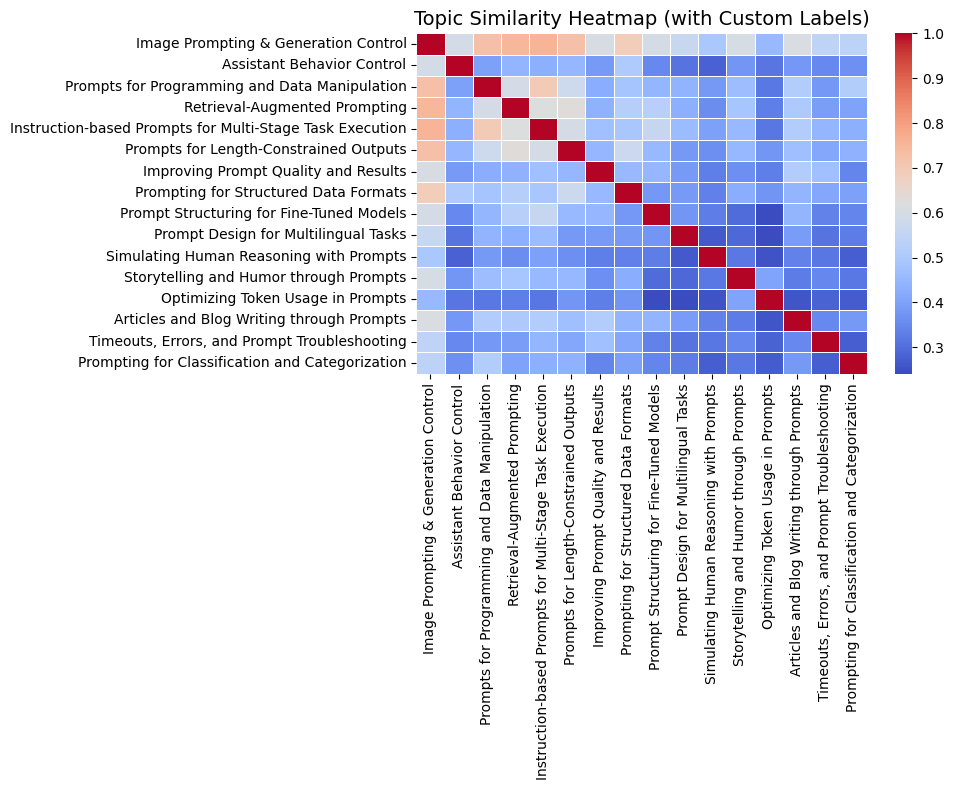

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract topic embeddings and calculate similarity
from sklearn.metrics.pairwise import cosine_similarity
embeddings = topic_model.c_tf_idf_.toarray()
similarity_matrix = cosine_similarity(embeddings)

# Step 2: Create label list
topic_info = topic_model.get_topic_info()
topic_info["Custom_Label"] = topic_info["Topic"].map(custom_topic_labels)
labels = topic_info[topic_info["Topic"] != -1]["Custom_Label"].tolist()
topic_indices = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

# Step 3: Subset matrix to exclude topic -1
sim_matrix_subset = similarity_matrix[topic_indices][:, topic_indices]

# Step 4: Plot
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix_subset,
            xticklabels=labels,
            yticklabels=labels,
            cmap="coolwarm",
            linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Topic Similarity Heatmap (with Custom Labels)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# Required: your original documents used to fit the model
documents = df["Lemmatized Post"].tolist()

# Optional: define subset of topics (e.g., top 10) or leave None
selected_topics = None  # or list like [0, 1, 2]

# Generate visualization
fig = topic_model.visualize_documents(documents, topics=selected_topics)

# Show in Colab
fig.show()


### Evolution of topics over time

Loaded 2693 documents with timestamps for dynamic modeling.


20it [00:06,  3.30it/s]


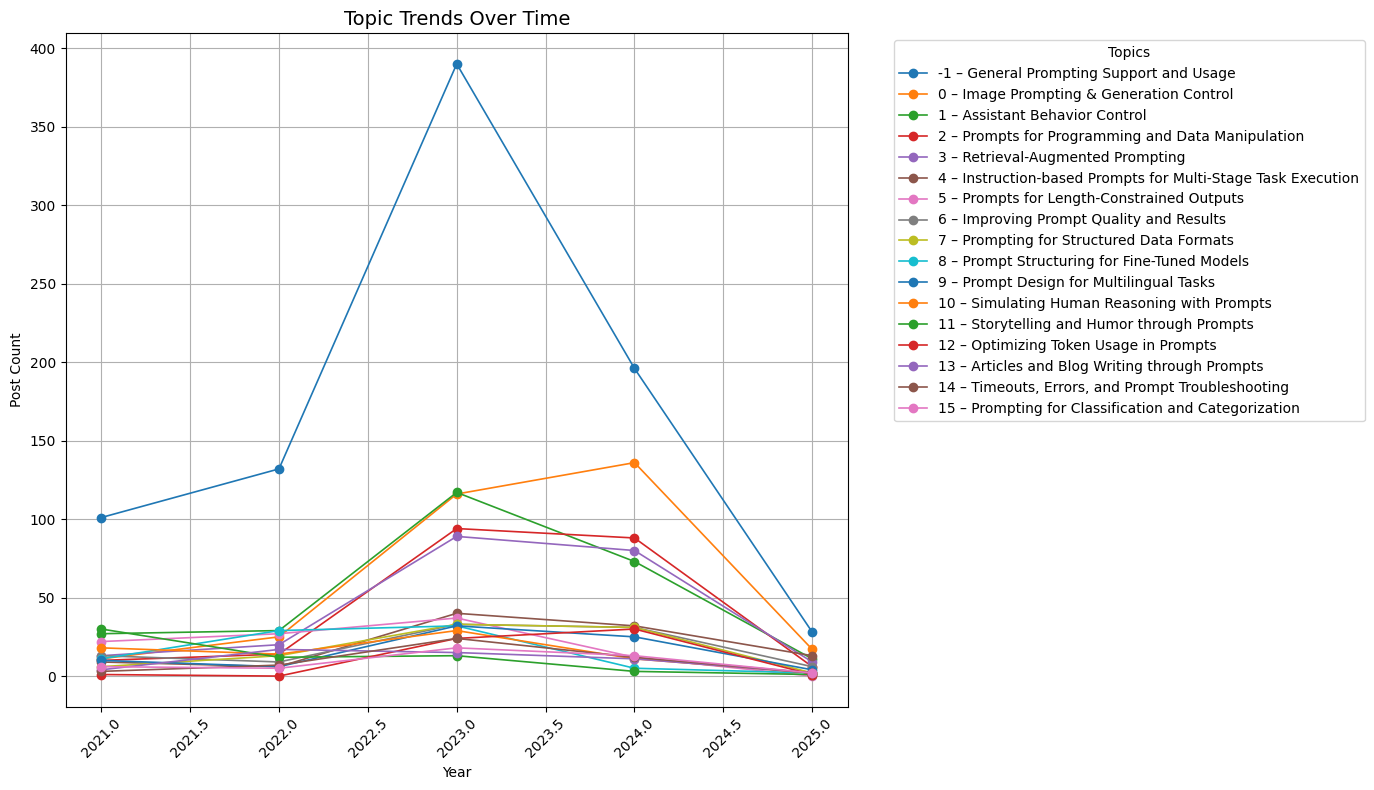

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 0: Define your custom topic label mapping
custom_topic_labels = {
    -1: "General Prompting Support and Usage",
     0: "Image Prompting & Generation Control",
     1: "Assistant Behavior Control",
     2: "Prompts for Programming and Data Manipulation",
     3: "Retrieval-Augmented Prompting",
     4: "Instruction-based Prompts for Multi-Stage Task Execution",
     5: "Prompts for Length-Constrained Outputs",
     6: "Improving Prompt Quality and Results",
     7: "Prompting for Structured Data Formats",
     8: "Prompt Structuring for Fine-Tuned Models",
     9: "Prompt Design for Multilingual Tasks",
    10: "Simulating Human Reasoning with Prompts",
    11: "Storytelling and Humor through Prompts",
    12: "Optimizing Token Usage in Prompts",
    13: "Articles and Blog Writing through Prompts",
    14: "Timeouts, Errors, and Prompt Troubleshooting",
    15: "Prompting for Classification and Categorization",
}

# Load and preprocess data
df = pd.read_csv(input_path)
df["Created At"] = pd.to_datetime(df["Created At"], format='ISO8601', errors='coerce')
df = df.dropna(subset=["Created At"])

documents = df["Lemmatized Post"].dropna().tolist()
timestamps = df["Created At"].tolist()

print(f"Loaded {len(documents)} documents with timestamps for dynamic modeling.")

# Compute topics over time
topics_over_time = topic_model.topics_over_time(
    documents,
    timestamps,
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=20
)

# Extract year from timestamp
topics_over_time["Year"] = pd.to_datetime(topics_over_time["Timestamp"]).dt.year

# Group by Topic and Year
yearly_counts = topics_over_time.groupby(["Topic", "Year"])["Frequency"].sum().reset_index()
pivot_df = yearly_counts.pivot(index="Year", columns="Topic", values="Frequency").fillna(0)

# Plot with clearer trend lines and custom legend
plt.figure(figsize=(14, 8))
for topic_id in pivot_df.columns:
    label = f"{topic_id} – {custom_topic_labels.get(topic_id, 'Unknown')}"
    plt.plot(pivot_df.index, pivot_df[topic_id], marker="o", linewidth=1.2, label=label)

plt.title("Topic Trends Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


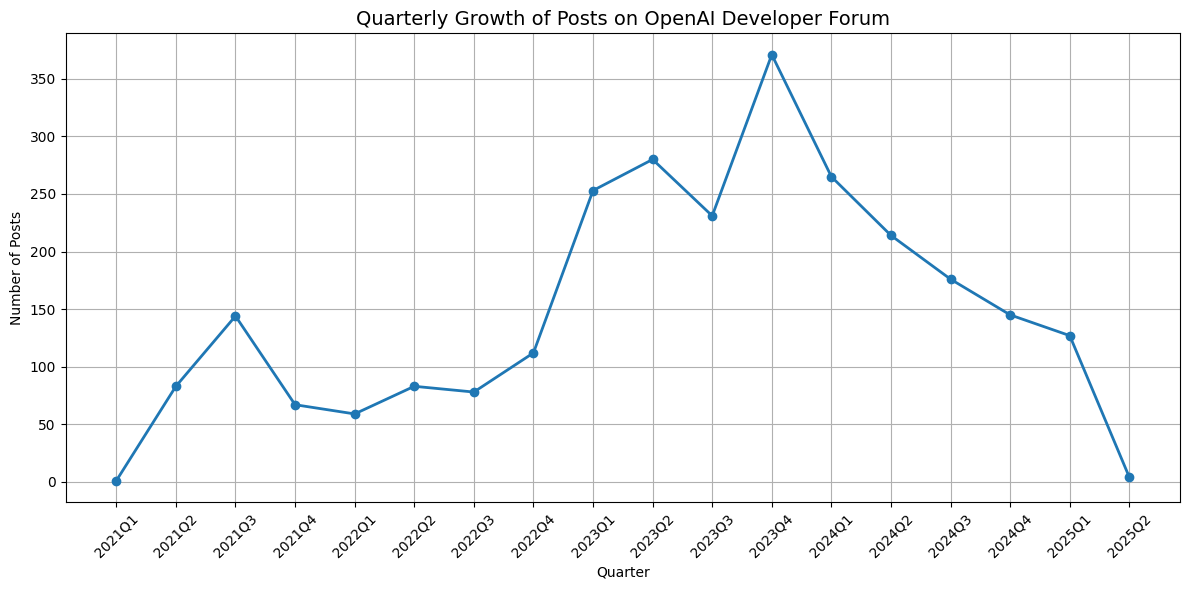

In [ ]:
# Convert to quarterly periods
df["Quarter"] = df["Created At"].dt.to_period("Q").astype(str)

# Count number of posts per quarter
quarterly_counts = df.groupby("Quarter").size().reset_index(name="Post Count")

# Plot the growth of posts by quarter
plt.figure(figsize=(12, 6))
plt.plot(quarterly_counts["Quarter"], quarterly_counts["Post Count"], marker="o", linewidth=2)
plt.title("Quarterly Growth of Posts on OpenAI Developer Forum", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


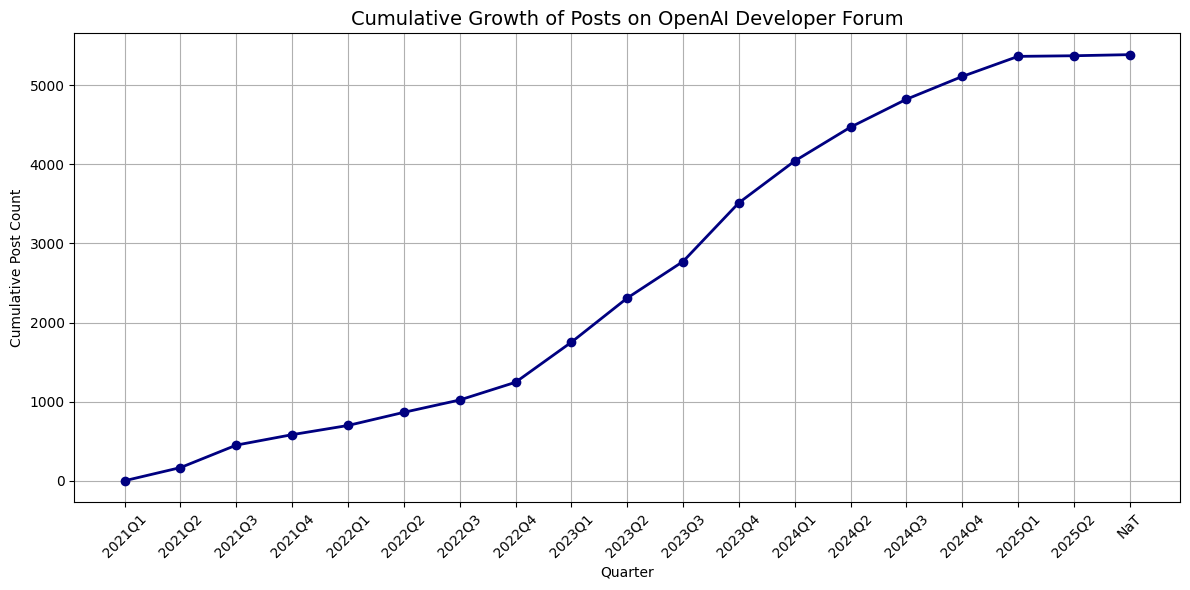

In [ ]:
# Re-import necessary libraries after code reset
import pandas as pd
import matplotlib.pyplot as plt

# Reload data
df = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")

# Convert to datetime
df["Created At"] = pd.to_datetime(df["Created At"], errors="coerce")

# Convert to quarterly periods
df["Quarter"] = df["Created At"].dt.to_period("Q").astype(str)

# Count number of posts per quarter
quarterly_counts = df.groupby("Quarter").size().reset_index(name="Post Count")

# Calculate cumulative sum
quarterly_counts["Cumulative Posts"] = quarterly_counts["Post Count"].cumsum()

# Plot the cumulative growth of posts by quarter
plt.figure(figsize=(12, 6))
plt.plot(quarterly_counts["Quarter"], quarterly_counts["Cumulative Posts"], marker="o", linewidth=2, color="navy")
plt.title("Cumulative Growth of Posts on OpenAI Developer Forum", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Cumulative Post Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define the folder containing the merged topic CSVs
merged_folder = Path("/content/drive/MyDrive/SW_PROJECT/topics_merged")
csv_files = list(merged_folder.glob("*.csv"))

# Load and concatenate all topic CSV files
merged_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Source_File"] = file.name  # Optionally add source file info
    merged_dfs.append(df)

# Combine into one DataFrame
combined_df = pd.concat(merged_dfs, ignore_index=True)

# Save to a new CSV
output_path = "/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv"
combined_df.to_csv(output_path, index=False)

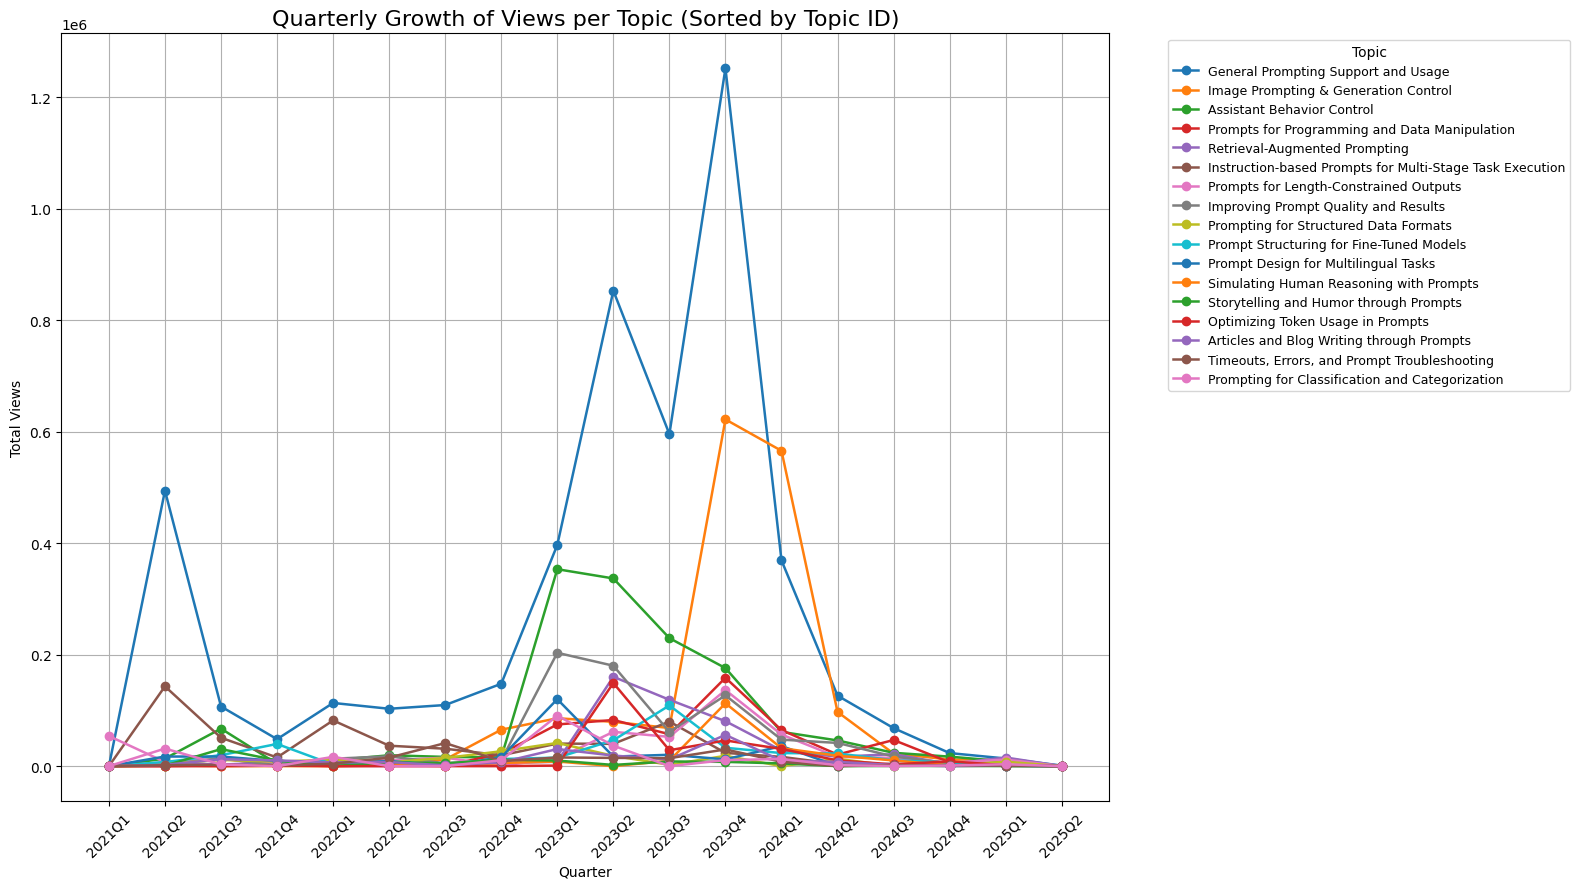

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined topic data and custom topic info
df_posts = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")
df_labels = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv")

# Preprocess
df_posts["Created At"] = pd.to_datetime(df_posts["Created At"], errors="coerce")
df_posts["Views"] = pd.to_numeric(df_posts["Views"], errors="coerce")
df_posts["Topic"] = pd.to_numeric(df_posts["Topic"], errors="coerce")
df_posts = df_posts.dropna(subset=["Created At", "Views", "Topic"])

# Merge with custom labels
label_map = df_labels.set_index("Topic")["Custom_Label"].to_dict()
df_posts["Custom_Label"] = df_posts["Topic"].map(label_map)

# Group by quarter and topic
df_posts["Quarter"] = df_posts["Created At"].dt.to_period("Q").astype(str)
quarterly_views = df_posts.groupby(["Quarter", "Custom_Label"])["Views"].sum().reset_index()

# Sort labels by topic number for consistent plotting order
sorted_labels = df_labels.sort_values("Topic")["Custom_Label"].tolist()

# Pivot for plotting
pivot_df = quarterly_views.pivot(index="Quarter", columns="Custom_Label", values="Views").fillna(0)

# Reorder columns using sorted topic labels
pivot_df = pivot_df[sorted_labels]

# Plot
plt.figure(figsize=(16, 9))
for topic in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[topic], marker="o", linewidth=1.8, label=topic)

plt.title("Quarterly Growth of Views per Topic (Sorted by Topic ID)", fontsize=16)
plt.xlabel("Quarter")
plt.ylabel("Total Views")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load post dataset
df = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")

# Preprocess
df["Replies"] = pd.to_numeric(df["Replies"], errors="coerce")
df["Topic"] = pd.to_numeric(df["Topic"], errors="coerce")
df = df.dropna(subset=["Replies", "Topic"])

# Adjust for actual replies (Replies - 1)
df["Actual_Replies"] = df["Replies"] - 1
df["Actual_Replies"] = df["Actual_Replies"].clip(lower=0)

# Load custom labels
label_map = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv").set_index("Topic")["Custom_Label"].to_dict()
df["Topic_Label"] = df["Topic"].map(label_map)

# Define reply bins
bins = [-1, 0, 2, 5, 10, float("inf")]
labels = ["0 Replies", "1-2 Replies", "3-5 Replies", "6-10 Replies", "10+ Replies"]
df["Reply_Bin"] = pd.cut(df["Actual_Replies"], bins=bins, labels=labels)

# Pivot to count
difficulty_table = df.pivot_table(index="Topic_Label", columns="Reply_Bin", aggfunc="size", fill_value=0)

# Add total column
difficulty_table["Total"] = difficulty_table.sum(axis=1)

# Sort by total
difficulty_table = difficulty_table.sort_values("Total", ascending=False)

# Display
from tabulate import tabulate
print(tabulate(difficulty_table.reset_index(), headers="keys", tablefmt="fancy_grid"))


╒════╤══════════════════════════════════════════════════════════╤═════════════╤═══════════════╤═══════════════╤════════════════╤═══════════════╤═════════╕
│    │ Topic_Label                                              │   0 Replies │   1-2 Replies │   3-5 Replies │   6-10 Replies │   10+ Replies │   Total │
╞════╪══════════════════════════════════════════════════════════╪═════════════╪═══════════════╪═══════════════╪════════════════╪═══════════════╪═════════╡
│  0 │ General Prompting Support and Usage                      │         210 │           540 │           496 │            266 │           182 │    1694 │
├────┼──────────────────────────────────────────────────────────┼─────────────┼───────────────┼───────────────┼────────────────┼───────────────┼─────────┤
│  1 │ Image Prompting & Generation Control                     │          96 │           194 │           160 │             76 │            84 │     610 │
├────┼──────────────────────────────────────────────────────────┼─────

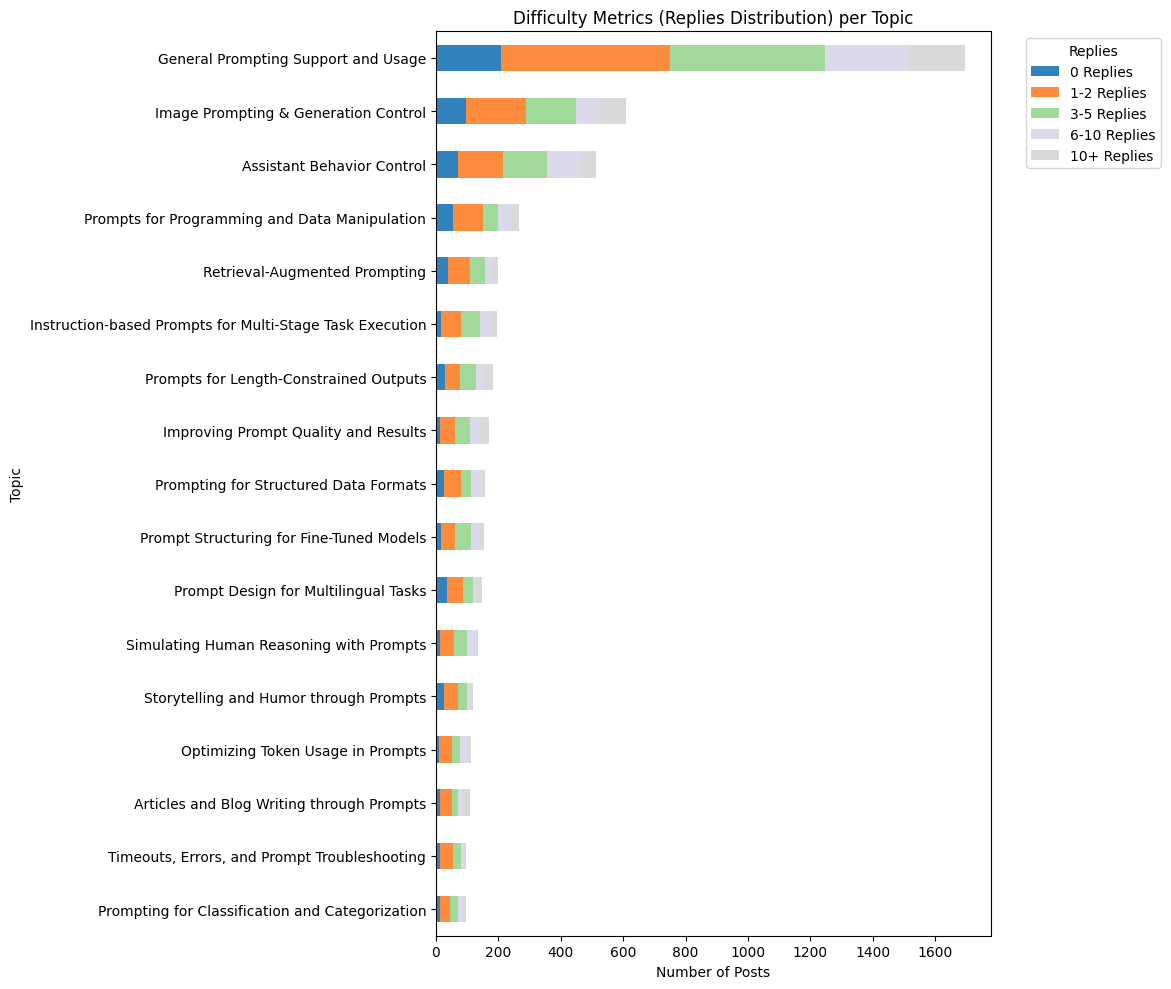

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")
labels_df = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv")

# Preprocessing
df["Replies"] = pd.to_numeric(df["Replies"], errors="coerce")
df["Topic"] = pd.to_numeric(df["Topic"], errors="coerce")
df = df.dropna(subset=["Replies", "Topic"])
df["Actual_Replies"] = df["Replies"] - 1
df["Actual_Replies"] = df["Actual_Replies"].clip(lower=0)

# Map custom labels
label_map = labels_df.set_index("Topic")["Custom_Label"].to_dict()
df["Topic_Label"] = df["Topic"].map(label_map)

# Bin replies
bins = [-1, 0, 2, 5, 10, float("inf")]
labels = ["0 Replies", "1-2 Replies", "3-5 Replies", "6-10 Replies", "10+ Replies"]
df["Reply_Bin"] = pd.cut(df["Actual_Replies"], bins=bins, labels=labels)

# Create pivot table
difficulty_table = df.pivot_table(index="Topic_Label", columns="Reply_Bin", aggfunc="size", fill_value=0)
difficulty_table["Total"] = difficulty_table.sum(axis=1)
difficulty_table = difficulty_table.sort_values("Total", ascending=False)

# Plot stacked bar chart
ax = difficulty_table[labels].plot(kind="barh", stacked=True, figsize=(12, 10), colormap="tab20c")
plt.xlabel("Number of Posts")
plt.ylabel("Topic")
plt.title("Difficulty Metrics (Replies Distribution) per Topic")
plt.legend(title="Replies", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.gca().invert_yaxis()

plt.show()


### Views-to-Reply ratio

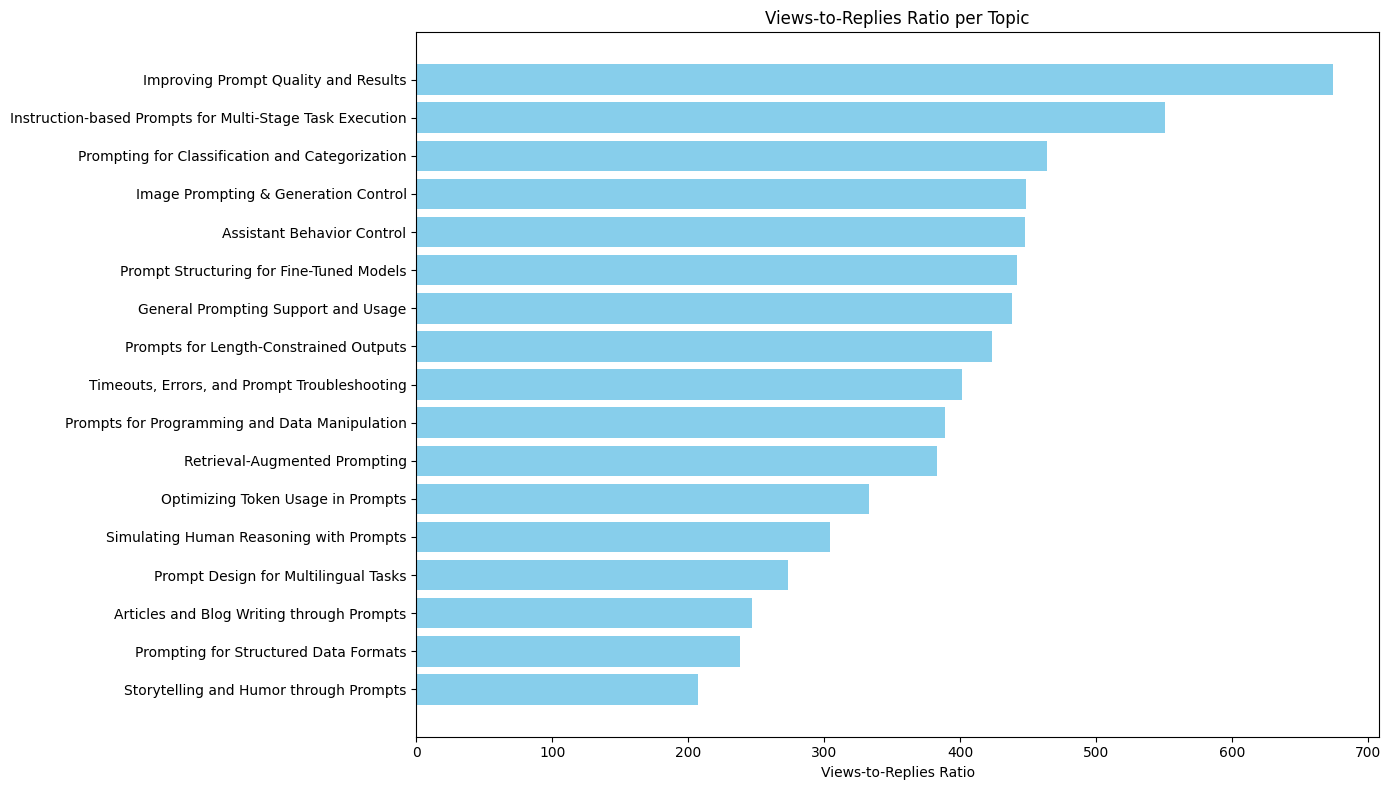

In [ ]:
# Load data
df_posts = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")
df_labels = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv")

# Preprocess
df_posts["Replies"] = pd.to_numeric(df_posts["Replies"], errors="coerce")
df_posts["Views"] = pd.to_numeric(df_posts["Views"], errors="coerce")
df_posts["Topic"] = pd.to_numeric(df_posts["Topic"], errors="coerce")
df_posts = df_posts.dropna(subset=["Topic", "Replies", "Views"])

# Compute aggregated views and replies per topic
df_ratio = df_posts.groupby("Topic")[["Views", "Replies"]].sum().reset_index()

# Avoid division by zero and compute ratio
df_ratio = df_ratio[df_ratio["Replies"] > 0]
df_ratio["Views_to_Replies_Ratio"] = df_ratio["Views"] / df_ratio["Replies"]

# Merge with custom topic labels
custom_labels = df_labels.set_index("Topic")["Custom_Label"].to_dict()
df_ratio["Custom_Label"] = df_ratio["Topic"].map(custom_labels)

# Drop rows with missing labels and make sure labels are strings
df_ratio = df_ratio.dropna(subset=["Custom_Label"])
df_ratio["Custom_Label"] = df_ratio["Custom_Label"].astype(str)

# Sort by ratio
df_ratio = df_ratio.sort_values("Views_to_Replies_Ratio", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
plt.barh(df_ratio["Custom_Label"], df_ratio["Views_to_Replies_Ratio"], color="skyblue")
plt.xlabel("Views-to-Replies Ratio")
plt.title("Views-to-Replies Ratio per Topic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Post-to-reply ratio

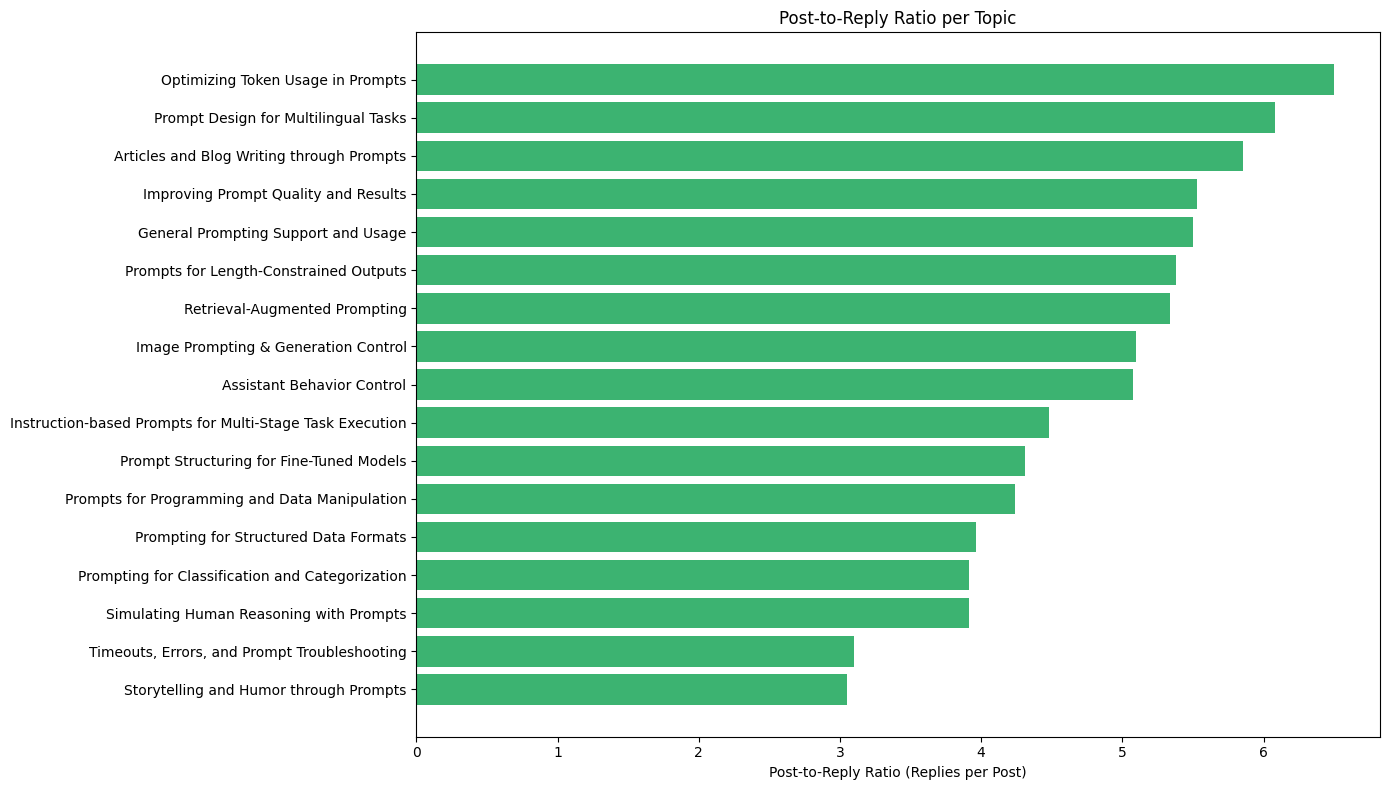

In [ ]:
# Load data
df_posts = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")
df_labels = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv")

# Preprocessing
df_posts["Replies"] = pd.to_numeric(df_posts["Replies"], errors="coerce")
df_posts["Topic"] = pd.to_numeric(df_posts["Topic"], errors="coerce")
df_posts = df_posts.dropna(subset=["Topic", "Replies"])

# Adjust for OpenAI logic: Replies - 1 = Actual replies
df_posts["Actual_Replies"] = df_posts["Replies"] - 1
df_posts["Actual_Replies"] = df_posts["Actual_Replies"].clip(lower=0)

# Aggregate replies and post counts per topic
summary = df_posts.groupby("Topic").agg(
    Total_Posts=("Title", "count"),
    Total_Replies=("Actual_Replies", "sum")
).reset_index()

# Compute post-to-reply ratio
summary["Post_to_Reply_Ratio"] = summary["Total_Replies"] / summary["Total_Posts"]

# Merge custom labels
custom_labels = df_labels.set_index("Topic")["Custom_Label"].to_dict()
summary["Custom_Label"] = summary["Topic"].map(custom_labels)

# Filter valid and sort
summary = summary.dropna(subset=["Custom_Label"])
summary["Custom_Label"] = summary["Custom_Label"].astype(str)
summary = summary.sort_values("Post_to_Reply_Ratio", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
plt.barh(summary["Custom_Label"], summary["Post_to_Reply_Ratio"], color="mediumseagreen")
plt.xlabel("Post-to-Reply Ratio (Replies per Post)")
plt.title("Post-to-Reply Ratio per Topic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Unique participants per topic

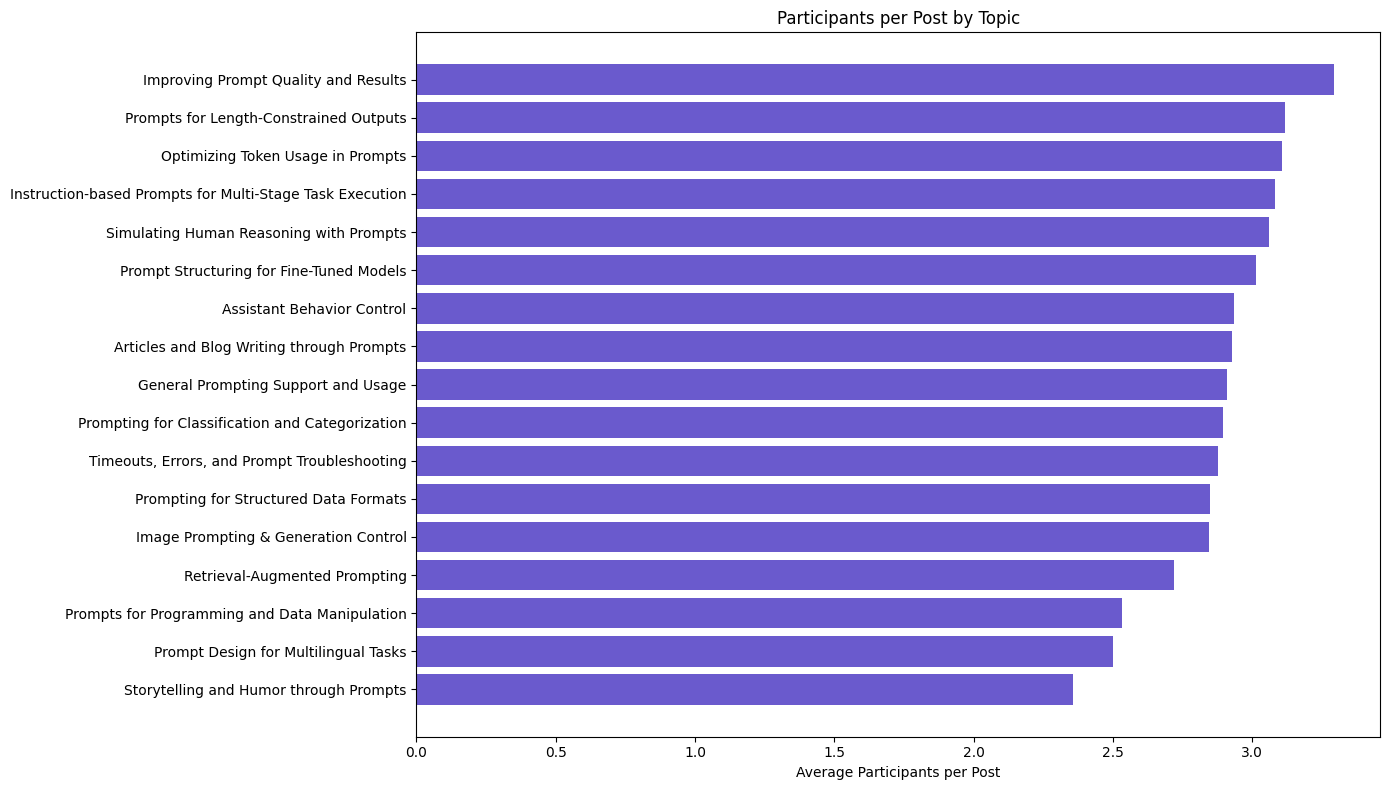

In [ ]:
# Load data
df_posts = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/all_topics_merged.csv")
df_labels = pd.read_csv("/content/drive/MyDrive/SW_PROJECT/topic_info_custom.csv")

# Preprocessing
df_posts["Participants"] = pd.to_numeric(df_posts["Participants"], errors="coerce")
df_posts["Topic"] = pd.to_numeric(df_posts["Topic"], errors="coerce")
df_posts = df_posts.dropna(subset=["Topic", "Participants"])

# Group by topic
summary = df_posts.groupby("Topic").agg(
    Total_Posts=("Title", "count"),
    Total_Participants=("Participants", "sum")
).reset_index()

# Calculate average participants per post
summary["Avg_Participants_per_Post"] = summary["Total_Participants"] / summary["Total_Posts"]

# Merge with labels
custom_labels = df_labels.set_index("Topic")["Custom_Label"].to_dict()
summary["Custom_Label"] = summary["Topic"].map(custom_labels)

# Filter and sort
summary = summary.dropna(subset=["Custom_Label"])
summary["Custom_Label"] = summary["Custom_Label"].astype(str)
summary = summary.sort_values("Avg_Participants_per_Post", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
plt.barh(summary["Custom_Label"], summary["Avg_Participants_per_Post"], color="slateblue")
plt.xlabel("Average Participants per Post")
plt.title("Participants per Post by Topic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
